In [1]:
!pip install -q transformers[torch]

In [2]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TextClassificationPipeline

bert_ckpt = "transformersbook/bert-base-uncased-finetuned-clinc"
bert_tokenizer = AutoTokenizer.from_pretrained(bert_ckpt)
bert_model = AutoModelForSequenceClassification.from_pretrained(bert_ckpt).to("cpu")
pipe = TextClassificationPipeline(model=bert_model, tokenizer=bert_tokenizer)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


In [3]:
query = """Hey, I'd like to rent a vehicle from Nov 1st to Nov 15th in
 Paris and I need a 15 passenger van"""
pipe(query)

[{'label': 'car_rental', 'score': 0.5490034222602844}]

In [4]:
class PerformanceBenchmark:
    def __init__(self, pipeline, dataset, optim_type="BERT baseline"):
        self.pipeline = pipeline
        self.dataset = dataset
        self.optim_type = optim_type

    def compute_accuracy(self):
        pass

    def compute_size(self):
        pass

    def time_pipeline(self):
        pass

    def run_benchmark(self):
        metrics = {}
        metrics[self.optim_type] = self.compute_size()
        metrics[self.optim_type].update(self.time_pipeline())
        metrics[self.optim_type].update(self.compute_accuracy())
        return metrics

In [5]:
!pip install -q -U datasets

In [6]:
from datasets import load_dataset

clinc = load_dataset("clinc_oos", "plus")
clinc

DatasetDict({
    train: Dataset({
        features: ['text', 'intent'],
        num_rows: 15250
    })
    validation: Dataset({
        features: ['text', 'intent'],
        num_rows: 3100
    })
    test: Dataset({
        features: ['text', 'intent'],
        num_rows: 5500
    })
})

In [7]:
clinc["test"][346]

{'text': 'is it possible to talk to you in mandarin', 'intent': 29}

In [8]:
intents = clinc["test"].features["intent"]
intents.int2str(clinc["test"][346]["intent"])

'change_language'

In [9]:
from datasets import load_metric
accuracy_score = load_metric("accuracy")
accuracy_score

<ipython-input-9-12db34b1ef1b>:2: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  accuracy_score = load_metric("accuracy")
/usr/local/lib/python3.10/dist-packages/datasets/load.py:753: FutureWarning: The repository for accuracy contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.17.1/metrics/accuracy/accuracy.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this metric from the next major release of `datasets`.
  warnings.warn(


Metric(name: "accuracy", features: {'predictions': Value(dtype='int32', id=None), 'references': Value(dtype='int32', id=None)}, usage: """
Args:
    predictions (`list` of `int`): Predicted labels.
    references (`list` of `int`): Ground truth labels.
    normalize (`boolean`): If set to False, returns the number of correctly classified samples. Otherwise, returns the fraction of correctly classified samples. Defaults to True.
    sample_weight (`list` of `float`): Sample weights Defaults to None.

Returns:
    accuracy (`float` or `int`): Accuracy score. Minimum possible value is 0. Maximum possible value is 1.0, or the number of examples input, if `normalize` is set to `True`.. A higher score means higher accuracy.

Examples:

    Example 1-A simple example
        >>> accuracy_metric = datasets.load_metric("accuracy")
        >>> results = accuracy_metric.compute(references=[0, 1, 2, 0, 1, 2], predictions=[0, 1, 1, 2, 1, 0])
        >>> print(results)
        {'accuracy': 0.5}

   

In [10]:
from tqdm.auto import tqdm

def compute_accuracy(self):
    preds, labels = [], []
    for example in tqdm(self.dataset):
        pred = self.pipeline(example["text"])[0]["label"]
        label = example["intent"]
        preds.append(intents.str2int(pred))
        labels.append(label)
    accuracy = accuracy_score.compute(predictions=preds, references=labels)
    print(f"Accuracy on test set - {accuracy['accuracy']: .3f}")
    return accuracy
PerformanceBenchmark.compute_accuracy = compute_accuracy

In [11]:
import torch
from pathlib import Path

def compute_size(self):
    state_dict = self.pipeline.model.state_dict()
    tmp_path = Path("model.pt")
    torch.save(state_dict, tmp_path)
    size_mb = Path(tmp_path).stat().st_size / (1024 * 1024)
    tmp_path.unlink()
    print(f"Model Size (MB) - {size_mb: .2f}")
    return {"size_mb": size_mb}

PerformanceBenchmark.compute_size = compute_size

In [12]:
from time import perf_counter

for _ in range(3):
    start_time = perf_counter()
    _ = pipe(query)
    latency = perf_counter() - start_time
    print(f"Latency(ms) - {latency * 1000:.3f}")

Latency(ms) - 181.158
Latency(ms) - 244.152
Latency(ms) - 331.657


In [13]:
import numpy as np

def time_pipeline(self, query="What is the pin number for my account?"):
    latencies = []
    for _ in range(10):
        _ = self.pipeline(query)
    for _ in range(100):
        start_time = perf_counter()
        _ = self.pipeline(query)
        latency = perf_counter() - start_time
        latencies.append(latency)

    time_avg_ms = 1000 * np.mean(latencies)
    time_std_ms = 1000 * np.std(latencies)
    print(f"Average latency(ms) - {time_avg_ms:.2f} +/- {time_std_ms:.2f}")
    return {"time_avg_ms": time_avg_ms, "time_std_ms": time_std_ms}

PerformanceBenchmark.time_pipeline = time_pipeline

In [84]:
pb = PerformanceBenchmark(pipe, clinc["test"])
perf_metrics = pb.run_benchmark()

Model Size (MB) -  255.88
Average latency(ms) - 87.85 +/- 24.39


  0%|          | 0/5500 [00:00<?, ?it/s]

Accuracy on test set -  0.856


In [14]:
from transformers import TrainingArguments

class DistillationTrainingArguments(TrainingArguments):
    def __init__(self, *args, alpha=0.5, temperature=2.0, **kwargs):
        super().__init__(*args, **kwargs)
        self.alpha = alpha
        self.temperature = temperature

In [81]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from transformers import Trainer

class DistillationTrainer(Trainer):
    def __init__(self, *args, teacher_model=None, **kwargs):
        super().__init__(*args, **kwargs)
        self.teacher_model = teacher_model

    def compute_loss(self, model, inputs, return_outputs=False):
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        inputs = inputs.to(device)

        # Forward pass through the student model
        outputs_stu = model(**inputs)
        logits_stu = outputs_stu.logits

        loss_ce = outputs_stu.loss

        # Compute knowledge distillation loss
        with torch.no_grad():
            outputs_tea = self.teacher_model(**inputs)
            logits_tea = outputs_tea.logits
            loss_fct = nn.KLDivLoss(reduction="batchmean")
            loss_kd = self.args.temperature ** 2 * loss_fct(
                F.log_softmax(logits_stu / self.args.temperature, dim=-1),
                F.softmax(logits_tea / self.args.temperature, dim=-1)
            )

        # Calculate the weighted sum of both losses
        loss = self.args.alpha * loss_ce + (1. - self.args.alpha) * loss_kd

        if return_outputs:
            return loss, outputs_stu
        else:
            return loss


In [78]:
student_ckpt = "distilbert-base-uncased"
student_tokenizer = AutoTokenizer.from_pretrained(student_ckpt)

def tokenize_text(batch, tokenizer):
    return tokenizer(batch["text"], truncation=True)

clinc_enc = clinc.map(tokenize_text, batched=True, remove_columns=["text"], fn_kwargs={"tokenizer": student_tokenizer})

clinc_enc = clinc_enc.rename_column("intent", "labels")

In [77]:
clinc_enc

DatasetDict({
    train: Dataset({
        features: ['intent', 'input_ids', 'attention_mask'],
        num_rows: 15250
    })
    validation: Dataset({
        features: ['intent', 'input_ids', 'attention_mask'],
        num_rows: 3100
    })
    test: Dataset({
        features: ['intent', 'input_ids', 'attention_mask'],
        num_rows: 5500
    })
})

In [17]:
import torch
from transformers import AutoConfig

num_labels = intents.num_classes
id2label = bert_model.config.id2label
label2id = bert_model.config.label2id
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

student_config = AutoConfig.from_pretrained(student_ckpt, num_labels=num_labels, id2label=id2label, label2id=label2id)

def student_init():
    return AutoModelForSequenceClassification.from_pretrained(student_ckpt, config=student_config).to(device)

In [18]:
def compute_metrics(pred):
    predictions, labels = pred
    predictions = np.argmax(predictions, axis=1)
    return accuracy_score.compute(predictions=predictions, references=labels)

In [23]:
batch_size=48
student_training_args = DistillationTrainingArguments(
    output_dir="checkpoints",
    evaluation_strategy="epoch",
    num_train_epochs=5,
    learning_rate=2e-5,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    alpha=1,
    weight_decay=0.01
)

In [82]:
teacher_checkpoint = "transformersbook/bert-base-uncased-finetuned-clinc"
teacher_model = AutoModelForSequenceClassification.from_pretrained(teacher_checkpoint, num_labels=num_labels).to(device)

distil_trainer = DistillationTrainer(
    model_init=student_init,
    teacher_model=teacher_model,
    args=student_training_args,
    train_dataset=clinc_enc["train"],
    eval_dataset=clinc_enc["validation"],
    compute_metrics=compute_metrics,
    tokenizer=student_tokenizer
)
distil_trainer.train()

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy
1,No log,3.303337,0.746452
2,3.807300,1.899217,0.864839
3,3.807300,1.178517,0.894194
4,1.720000,0.875852,0.909355
5,0.920800,0.792727,0.915161


TrainOutput(global_step=1590, training_loss=2.072857392509029, metrics={'train_runtime': 304.7559, 'train_samples_per_second': 250.2, 'train_steps_per_second': 5.217, 'total_flos': 413455351535688.0, 'train_loss': 2.072857392509029, 'epoch': 5.0})

In [85]:
pipe = TextClassificationPipeline(
    model=distil_trainer.model.to("cpu"), tokenizer=distil_trainer.tokenizer
)
optim_type = "DistilBERT"
pb = PerformanceBenchmark(pipe, clinc["test"], optim_type=optim_type)
perf_metrics.update(pb.run_benchmark())

Model Size (MB) -  255.88
Average latency(ms) - 86.84 +/- 22.94


  0%|          | 0/5500 [00:00<?, ?it/s]

Accuracy on test set -  0.856


In [96]:
perf_metrics

{'BERT baseline': {'size_mb': 255.88184547424316,
  'time_avg_ms': 87.85066377997282,
  'time_std_ms': 24.39386715559984,
  'accuracy': 0.856},
 'DistilBERT': {'size_mb': 255.88184547424316,
  'time_avg_ms': 86.83729184001095,
  'time_std_ms': 22.94154014402168,
  'accuracy': 0.856}}

BERT baseline
DistilBERT
Here


<ipython-input-100-ea08f3039dbb>:17: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  for handle in legend.legendHandles:


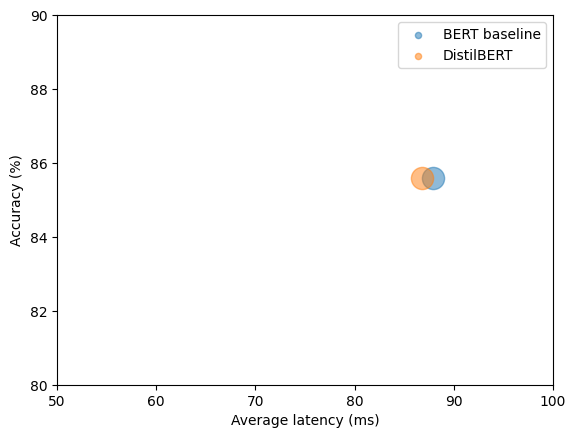

In [100]:
import pandas as pd
import matplotlib.pyplot as plt


def plot_metrics(perf_metrics, current_optim_type):
    df = pd.DataFrame.from_dict(perf_metrics, orient="index")

    for idx in df.index:
        df_opt = df.loc[idx]
        print(idx)
        if idx == current_optim_type:
            print("Here")
            plt.scatter(df_opt["time_avg_ms"], df_opt["accuracy"] * 100, alpha=0.5, s=df_opt["size_mb"], label=idx, marker='o')
        else:
            plt.scatter(df_opt["time_avg_ms"], df_opt["accuracy"] * 100, alpha=0.5, s=df_opt["size_mb"], label=idx)
    legend = plt.legend(bbox_to_anchor=(1, 1))
    for handle in legend.legendHandles:
        handle.set_sizes([20])
    plt.ylim(80, 90)
    plt.xlim(50, 100)
    plt.ylabel("Accuracy (%)")
    plt.xlabel("Average latency (ms)")
    plt.show()

plot_metrics(perf_metrics, optim_type)


In [104]:
def objective(trial):
    x = trial.suggest_float("x", -2, 2)
    y = trial.suggest_float("y", -2, 2)
    return (1 - x) ** 2 + 100 * (y - x ** 2) ** 2


In [101]:
!pip install optuna

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 413.4/413.4 kB 5.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.4/233.4 kB 8.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 kB 11.4 MB/s eta 0:00:00


In [105]:
import optuna

study = optuna.create_study()
study.optimize(objective, n_trials=1000)
study.best_params

[I 2024-02-27 16:45:50,806] A new study created in memory with name: no-name-2964e6c7-b171-4092-9731-8f01d64bfd3d
[I 2024-02-27 16:45:50,810] Trial 0 finished with value: 1035.501904843627 and parameters: {'x': -1.7838463690149382, 'y': -0.023749433999701086}. Best is trial 0 with value: 1035.501904843627.
[I 2024-02-27 16:45:50,813] Trial 1 finished with value: 2146.810913136457 and parameters: {'x': -1.9714784676946535, 'y': -0.7371035618762858}. Best is trial 0 with value: 1035.501904843627.
[I 2024-02-27 16:45:50,822] Trial 2 finished with value: 1458.1845297169439 and parameters: {'x': -1.9061823766815817, 'y': -0.17401209354229952}. Best is trial 0 with value: 1035.501904843627.
[I 2024-02-27 16:45:50,830] Trial 3 finished with value: 372.0033772678194 and parameters: {'x': 0.4187832031509986, 'y': -1.7524836018530987}. Best is trial 3 with value: 372.0033772678194.
[I 2024-02-27 16:45:50,832] Trial 4 finished with value: 72.84117676474794 and parameters: {'x': 0.4238739473343309

{'x': 1.0332359058544358, 'y': 1.0645894602684278}

In [106]:
study.best_params

{'x': 1.0332359058544358, 'y': 1.0645894602684278}

In [107]:
def hp_space(trial):
    return {
        "num_train_epochs": trial.suggest_int("num_train_epochs", 5, 10),
        "alpha": trial.suggest_float("alpha", 0, 1),
        "temperature": trial.suggest_float("temperature", 2, 20)
    }

In [ ]:
best_run = distil_trainer.hyperparameter_search(
    n_trials=20, direction="maximize", hp_space=hp_space
)
best_run

[I 2024-02-27 16:46:27,416] A new study created in memory with name: no-name-f2614ef5-0884-418b-bb79-03a6a5d60657
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.584010,0.007419
2,0.591100,0.584005,0.007419
3,0.591100,0.584006,0.007419
4,0.590300,0.584005,0.007419
5,0.589900,0.584005,0.007419


[I 2024-02-27 16:51:35,445] Trial 0 finished with value: 0.007419354838709678 and parameters: {'num_train_epochs': 5, 'alpha': 0.6088030137813978, 'temperature': 18.167557176220612}. Best is trial 0 with value: 0.007419354838709678.
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.935852,0.007419
2,0.962200,0.935850,0.007419
3,0.962200,0.935849,0.007419
4,0.961700,0.935848,0.007419
5,0.961300,0.935847,0.007419
6,0.961300,0.935847,0.007419
7,0.962200,0.935847,0.007419


[I 2024-02-27 16:58:30,964] Trial 1 finished with value: 0.007419354838709678 and parameters: {'num_train_epochs': 7, 'alpha': 0.3606119643298067, 'temperature': 2.445007047122913}. Best is trial 0 with value: 0.007419354838709678.
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.586696,0.007419
2,0.593900,0.586695,0.007419
3,0.593900,0.586693,0.007419
4,0.593100,0.586691,0.007419
5,0.592700,0.586692,0.007419


[I 2024-02-27 17:03:27,668] Trial 2 finished with value: 0.007419354838709678 and parameters: {'num_train_epochs': 5, 'alpha': 0.4813365317837348, 'temperature': 16.684352553568793}. Best is trial 0 with value: 0.007419354838709678.
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.596123,0.007419
2,0.603600,0.596121,0.007419
3,0.603600,0.596120,0.007419
4,0.602800,0.596119,0.007419
5,0.602400,0.596118,0.007419
6,0.602400,0.596118,0.007419
7,0.603300,0.596116,0.007419
8,0.603400,0.596116,0.007419
9,0.603400,0.596116,0.007419


[I 2024-02-27 17:12:35,373] Trial 3 finished with value: 0.007419354838709678 and parameters: {'num_train_epochs': 9, 'alpha': 0.28797993862522797, 'temperature': 13.065143597130302}. Best is trial 0 with value: 0.007419354838709678.
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.604213,0.007419
2,0.612000,0.604212,0.007419
3,0.612000,0.604211,0.007419
4,0.611200,0.604210,0.007419
5,0.610800,0.604208,0.007419
6,0.610800,0.604208,0.007419
7,0.611700,0.604208,0.007419
8,0.611800,0.604208,0.007419


[I 2024-02-27 17:21:03,613] Trial 4 finished with value: 0.007419354838709678 and parameters: {'num_train_epochs': 8, 'alpha': 0.061175578197924074, 'temperature': 11.094529870197993}. Best is trial 0 with value: 0.007419354838709678.
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.900991,0.007419
2,0.925000,0.900989,0.007419
3,0.925000,0.900988,0.007419
4,0.924500,0.900987,0.007419
5,0.924100,0.900986,0.007419
6,0.924100,0.900986,0.007419


[I 2024-02-27 17:27:12,826] Trial 5 finished with value: 0.007419354838709678 and parameters: {'num_train_epochs': 6, 'alpha': 0.6735104979605935, 'temperature': 2.58598191175001}. Best is trial 0 with value: 0.007419354838709678.
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.589676,0.007419
2,0.597000,0.589675,0.007419
3,0.597000,0.589673,0.007419
4,0.596200,0.589672,0.007419
5,0.595800,0.589672,0.007419
6,0.595800,0.589670,0.007419
7,0.596700,0.589669,0.007419
8,0.596700,0.589669,0.007419
9,0.596700,0.589669,0.007419


[I 2024-02-27 17:36:24,569] Trial 6 finished with value: 0.007419354838709678 and parameters: {'num_train_epochs': 9, 'alpha': 0.6673951912173799, 'temperature': 15.318988962137341}. Best is trial 0 with value: 0.007419354838709678.
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.590215,0.007419
2,0.597500,0.590212,0.007419
3,0.597500,0.590211,0.007419
4,0.596700,0.590209,0.007419
5,0.596300,0.590208,0.007419
6,0.596300,0.590208,0.007419
7,0.597200,0.590207,0.007419
8,0.597300,0.590205,0.007419


Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.590215,0.007419
2,0.597500,0.590212,0.007419
3,0.597500,0.590211,0.007419
4,0.596700,0.590209,0.007419
5,0.596300,0.590208,0.007419
6,0.596300,0.590208,0.007419
7,0.597200,0.590207,0.007419
8,0.597300,0.590205,0.007419
9,0.597300,0.590205,0.007419
10,0.596700,0.590205,0.007419


[I 2024-02-27 17:46:58,834] Trial 7 finished with value: 0.007419354838709678 and parameters: {'num_train_epochs': 10, 'alpha': 0.20312840916184527, 'temperature': 15.098374384001673}. Best is trial 0 with value: 0.007419354838709678.
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.608775,0.007419
2,0.616800,0.608775,0.007419
3,0.616800,0.608773,0.007419
4,0.615900,0.608772,0.007419
5,0.615600,0.608771,0.007419
6,0.615600,0.608771,0.007419


[I 2024-02-27 17:53:22,277] Trial 8 finished with value: 0.007419354838709678 and parameters: {'num_train_epochs': 6, 'alpha': 0.3659277568474463, 'temperature': 10.250801875021532}. Best is trial 0 with value: 0.007419354838709678.
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.619193,0.007419
2,0.627600,0.619191,0.007419


In [ ]:
for k, v in best_run.hyperparameters.items():
    setattr(distil_trainer.args, k, v)

distil_trainer.train()